# Speech Emotion Recognition
Speech emotion recognition is a field of study that aims to identify and understand the emotional state of a speaker by analyzing their speech. This can be done through various techniques such as identifying specific words or phrases that are indicative of a particular emotion, or by analyzing the `pitch`, `rhythm`, and `intonation` of the speaker's voice.

The technology is used in a variety of applications such as `virtual assistants`, `customer service`, and `healthcare`. It is also used to study the `human emotions`, `communication` and `behavior`. With the help of speech emotion recognition, researchers can gain insights into how emotions affect human interactions, and how emotions can be used to improve human-computer interactions.

In [118]:
import keras
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.core.display import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import librosa.display
import librosa
import os

import warnings
warnings.simplefilter("ignore")

## Create the dataframes

In [119]:
crema_directory_list = os.listdir("./data/Crema")

file_emotion = []
file_path = []

print(len(crema_directory_list))
for file in crema_directory_list:
    # store the file paths
    file_path.append("data/Crema/" + file)

    # store the file emot   ions
    emotion = file.split("_")[2]

    if emotion == "SAD": file_emotion.append("sad")
    elif emotion == "ANG": file_emotion.append("angry")
    elif emotion == "DIS": file_emotion.append("disgust")
    elif emotion == "FEA": file_emotion.append("fear")
    elif emotion == "HAP": file_emotion.append("happy")
    elif emotion == "NEU": file_emotion.append("neutral")
    else: file_emotion.append("unknown")

# dataframe: emotions
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])

# dataframe: path of files
path_df = pd.DataFrame(file_path, columns=["Path"])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

7442


,Emotions,Path
0,angry,data/Crema/1001_DFA_ANG_XX.wav
1,disgust,data/Crema/1001_DFA_DIS_XX.wav
2,fear,data/Crema/1001_DFA_FEA_XX.wav
3,happy,data/Crema/1001_DFA_HAP_XX.wav
4,neutral,data/Crema/1001_DFA_NEU_XX.wav


In [120]:
data = emotion_df
data.head()

,Emotions
0,angry
1,disgust
2,fear
3,happy
4,neutral


## Data Visualization

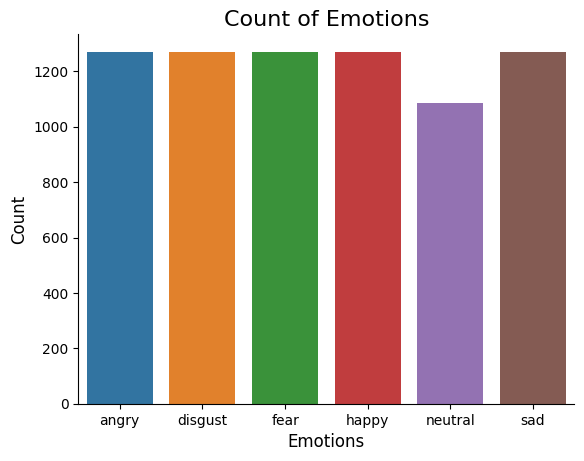

In [121]:
plt.title("Count of Emotions", size=16)
sns.countplot(data=data, x="Emotions")
plt.ylabel("Count", size=12)
plt.xlabel("Emotions", size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Additionally, Waveplots and Spectograms can help us visualize the data better:
* Waveplots: Let us know the loudness of the audio at a given time
* Spectograms: Visual representation of the spectrum of frequencies of sound as they vary with time

In [122]:
def generate_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(emotion + " Waveplot", size=15)
    librosa.display.waveshow(y=data, sr=sampling_rate)
    plt.show()
    
def generate_spectogram(data, sampling_rate, emotion):
    # stft: short term fourier transform
    amplitude = librosa.stft(data)
    db = librosa.amplitude_to_db(abs(amplitude))
    plt.figure(figsize=(12, 3))
    plt.title(emotion + " Spectogram", size=15)
    librosa.display.specshow(db, sr=sampling_rate, x_axis="time", y_axis="hz")
    plt.colorbar()

def visualize_audio(emotion):
    path = np.array(crema_df.Path[crema_df.Emotions==emotion])[1]
    audio, sampling_rate = librosa.load(path)
    generate_waveplot(audio, sampling_rate, emotion)
    generate_spectogram(audio, sampling_rate, emotion)
    display(Audio(path))

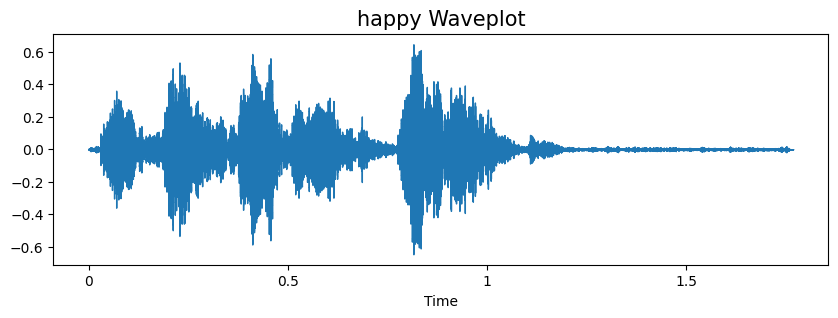

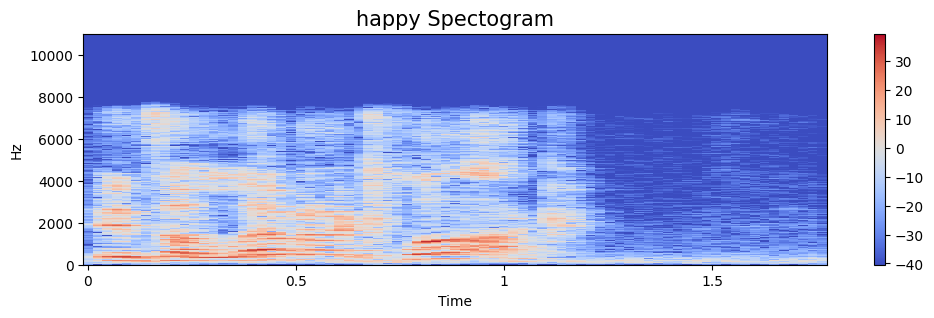

In [123]:
visualize_audio("happy")

## Augmentation

In [124]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(crema_df.Path)[1]
data, sample_rate = librosa.load(path)

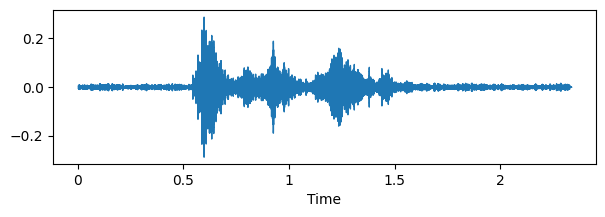

In [125]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

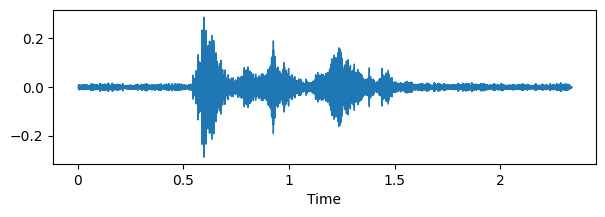

In [126]:
x = noise(data)
plt.figure(figsize=(7, 2))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

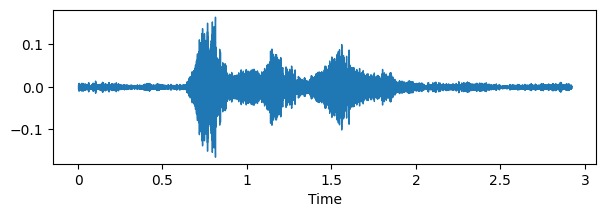

In [127]:
x = stretch(data)
plt.figure(figsize=(7, 2))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

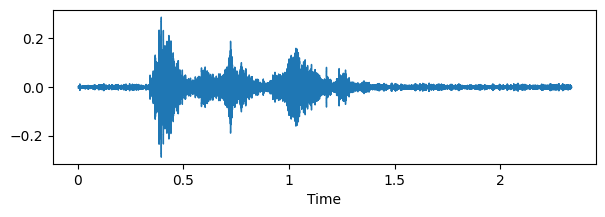

In [128]:
x = shift(data)
plt.figure(figsize=(7, 2))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

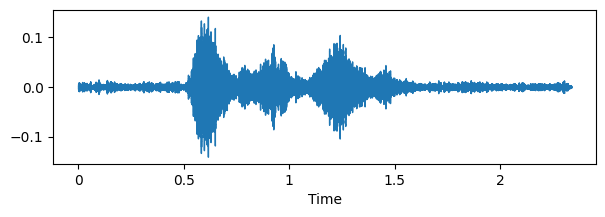

In [129]:
x = pitch(data, sample_rate)
plt.figure(figsize=(7, 2))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

In [130]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [134]:
X, Y = [], []
print(len(crema_df.Emotions))
i = 0
for path, emotion in zip(crema_df.Path, crema_df.Emotions):
    if not i % 100:
        print(i)
    i += 1
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

7442
0
100
200
300
400


In [ ]:
len(X), len(Y), crema_df.Path.shape

(10032, 10032, (7442,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,labels
0,None,angry
1,None,angry
2,None,angry
3,None,disgust
4,None,disgust


## Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [133]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

AttributeError: 'list' object has no attribute 'shape'

In [132]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7524, 1, 1), (7524, 6), (2508, 1, 1), (2508, 6))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 256)            1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 256)            327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 128)            163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 128)          

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type NoneType).

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))